<a href="https://colab.research.google.com/github/AnuBaluguri/DeepFake-Detection/blob/main/XceptioinNet11thDec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from google.colab import drive

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load preprocessed data
X_train = np.load('/content/drive/MyDrive/Deepfake Detection Data/X_train.npy')
X_test = np.load('/content/drive/MyDrive/Deepfake Detection Data/X_test.npy')
y_train = np.load('/content/drive/MyDrive/Deepfake Detection Data/y_train.npy')
y_test = np.load('/content/drive/MyDrive/Deepfake Detection Data/y_test.npy')

In [ ]:
# Define the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model to use pretrained weights
base_model.trainable = False

In [ ]:
# Add custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: deepfake (1) and original (0)
])

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Deepfake Detection Data/best_xception_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               mode='max',
                               verbose=1)


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.4398 - loss: 0.8277
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to /content/drive/MyDrive/Deepfake Detection Data/best_xception_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.4492 - loss: 0.8196 - val_accuracy: 0.6250 - val_loss: 0.5579
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6309 - loss: 0.6475
Epoch 2: val_accuracy improved from 0.62500 to 0.68750, saving model to /content/drive/MyDrive/Deepfake Detection Data/best_xception_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 403ms/step - accuracy: 0.6286 - loss: 0.6501 - val_accuracy: 0.6875 - val_loss: 0.5486
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6848 - loss: 0.7109
Epoch 3: val_accuracy did not improve from 0.68750
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.6874 - loss: 0.7042 - val_accuracy: 0.6458 - val_loss: 0.5102
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.62

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.9778 - loss: 0.4136
Test Accuracy: 96.67%


In [ ]:
# Save final model
model.save('/content/drive/MyDrive/Deepfake Detection Data/final_xception_model.h5')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load test predictions
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class predictions
y_true = y_test.argmax(axis=1)  # True labels


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

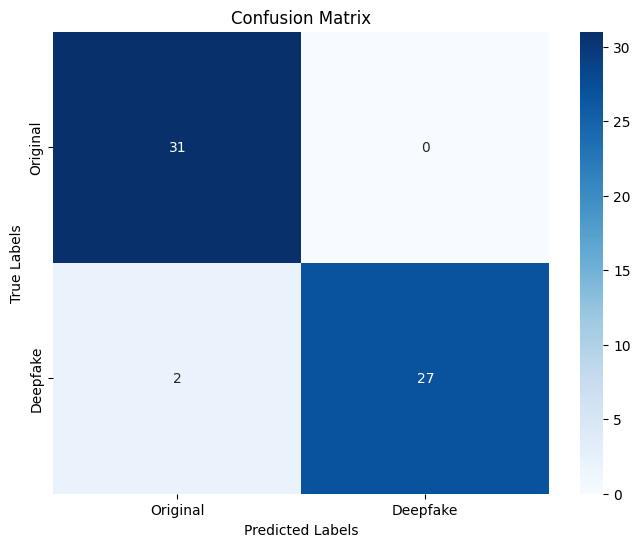

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Original', 'Deepfake']))

Classification Report:
              precision    recall  f1-score   support

    Original       0.94      1.00      0.97        31
    Deepfake       1.00      0.93      0.96        29

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



In [ ]:
# Retrieve training history
history_dict = history.history


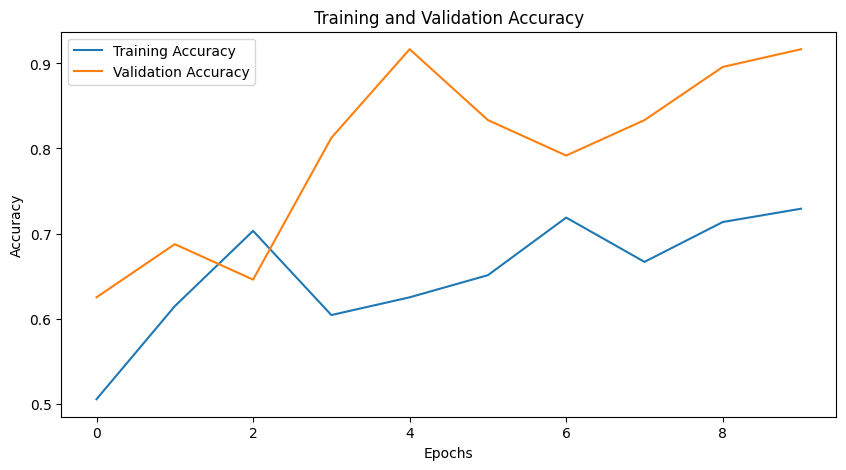

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()